# Feature Engineering Notebook

This notebook takes the reconfigured files from the first notebook and explores the data.  We create new features and get the data in the proper format for analysis.  

In [237]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
import datatools

%matplotlib inline

In [238]:
#Bring in the data

nba = pd.read_csv('./data/nba_combined.csv')
nba.dropna(inplace = True)

In [239]:
#bring in test data 
nba_test = pd.read_csv('./data/nba_test.csv')

### Look at the Data

Let us look at the Distribution of the win margins that we will try and predict as well as how well the line does in separating the data.

We also want to look at the value of the points throughout the dataset. As line shopping can be an important factor in final win percentage. 

In [240]:
print('The standard deviation of the Win Margins is ',np.std(nba.home_win_margin))
print('The mean home winning margin is ', nba.home_win_margin.mean())

The standard deviation of the Win Margins is  13.246634619057609
The mean home winning margin is  3.0327209479291226


In [241]:
graph = datatools.DataGrapher()

Let Graph


In [242]:
graph.getdata(nba)

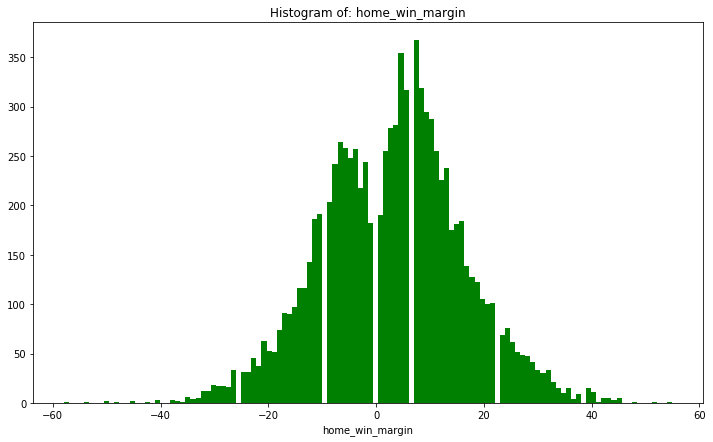

In [243]:
graph.plothist('home_win_margin', bins = 120)

In [244]:
nba.home_win_margin.value_counts(normalize= True)

 7.0     0.039896
 5.0     0.038482
 8.0     0.034678
 6.0     0.034460
 9.0     0.032069
 10.0    0.031308
 4.0     0.030547
 3.0     0.030221
-7.0     0.028699
-6.0     0.028047
-4.0     0.027938
 2.0     0.027720
 11.0    0.027720
-5.0     0.026959
-2.0     0.026525
-8.0     0.026307
 13.0    0.025872
 12.0    0.024568
-3.0     0.023698
-9.0     0.022068
-10.0    0.020763
 1.0     0.020654
-11.0    0.020220
 16.0    0.020002
-1.0     0.019785
 15.0    0.019676
 14.0    0.019024
-12.0    0.015545
 17.0    0.015110
 18.0    0.013806
           ...   
 36.0    0.001631
 34.0    0.001631
 39.0    0.001631
-32.0    0.001304
-31.0    0.001304
 40.0    0.001196
 35.0    0.001087
 38.0    0.000978
-35.0    0.000652
 42.0    0.000544
 45.0    0.000544
-33.0    0.000544
 43.0    0.000544
 37.0    0.000435
-34.0    0.000435
-41.0    0.000326
 44.0    0.000326
-38.0    0.000326
-50.0    0.000217
-45.0    0.000217
-37.0    0.000217
-58.0    0.000109
 55.0    0.000109
 41.0    0.000109
 52.0    0

Here we can see the importance of some numbers.  The most common outcome is the a home win of 7 that occurs 3.96% of the time.  Since we need 52.38% win rate getting a better line can in many cases overcome the percentage needed to win. Thus it can be critical to have multiple line options

In [245]:
print('The standard deviation of bookmaker errors ',np.std(nba.line_cv))
print('The mean of bookmaker errors', nba.line_cv.mean())

The standard deviation of bookmaker errors  11.785008112805489
The mean of bookmaker errors -0.2845363626481139


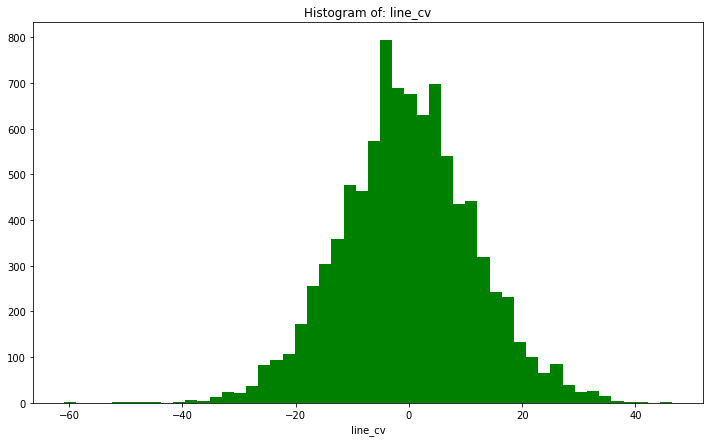

In [246]:
graph.plothist('line_cv')

The Error from the line is pretty normally distributed around zero.  With a mean of .2 and standard deviation of 11.  The standard deviation is high but that is to be expected.  Anyone that has ever watch an NBA game knows that there is large variance at the end of games with teams fouling and shooting with irregularity based on no real reason other than that games characteristics

In [247]:
print('The standard deviation of home_win_margin ',np.std(nba.home_win_margin))
print('The mean of home_win_margin', nba.home_win_margin.mean())

The standard deviation of home_win_margin  13.246634619057609
The mean of home_win_margin 3.0327209479291226


In [248]:
nba.cover.value_counts()

0    4817
1    4382
Name: cover, dtype: int64

In [249]:
nba.cover.value_counts(normalize = True)

0    0.523644
1    0.476356
Name: cover, dtype: float64

When we look at the away covers we can see the number of pushes is just under 2%. Currently pushes are considered losses but the values need to be recalibrated to 0 since a push is equivalent to a no bet.

The actual ratio of away to home covers would be 

         .4763 / .4763 + 5037 = 48.6% 


In [250]:
nba.away_cover.value_counts(normalize = True)

1    0.50375
0    0.49625
Name: away_cover, dtype: float64

Historically the away team has covered 51.4% of the time.  This would suggest that it might be easiest to identify away teams to beat the 52.38 percent mark.

### Calulate returns to account for pushes

In reality this is a multinomial categorization problem as there is a push class.  It is roughly 2% of the data.  However, I am uninterested in the push class.  However, I calculate the payout since I am combining it with the negative class. I can get a better idea of the payout by subtracting out the pushes at the end of the analysis

In [251]:
conditions = [
    (nba['line_cv'] <0), 
    (nba['line_cv'] > 0),
    (nba['line_cv'] == 0)]
choices = [.909, -1, 0]
nba['away_payout'] = np.select(conditions, choices)

In [252]:
#test payouts
conditions = [
    (nba_test['line_cv'] <0), 
    (nba_test['line_cv'] > 0),
    (nba_test['line_cv'] == 0)]
choices = [.909, -1, 0]
nba_test['away_payout'] = np.select(conditions, choices)

In [253]:
nba.away_payout.value_counts()

 0.909    4634
-1.000    4382
 0.000     183
Name: away_payout, dtype: int64

In [254]:
conditions = [
    (nba['line_cv'] >0), 
    (nba['line_cv'] < 0),
    (nba['line_cv'] == 0)]
choices = [.909, -1, 0]
nba['home_payout'] = np.select(conditions, choices)

In [255]:
conditions = [
    (nba_test['line_cv'] >0), 
    (nba_test['line_cv'] < 0),
    (nba_test['line_cv'] == 0)]
choices = [.909, -1, 0]
nba_test['home_payout'] = np.select(conditions, choices)

In [256]:
nba.home_payout.value_counts()

-1.000    4634
 0.909    4382
 0.000     183
Name: home_payout, dtype: int64

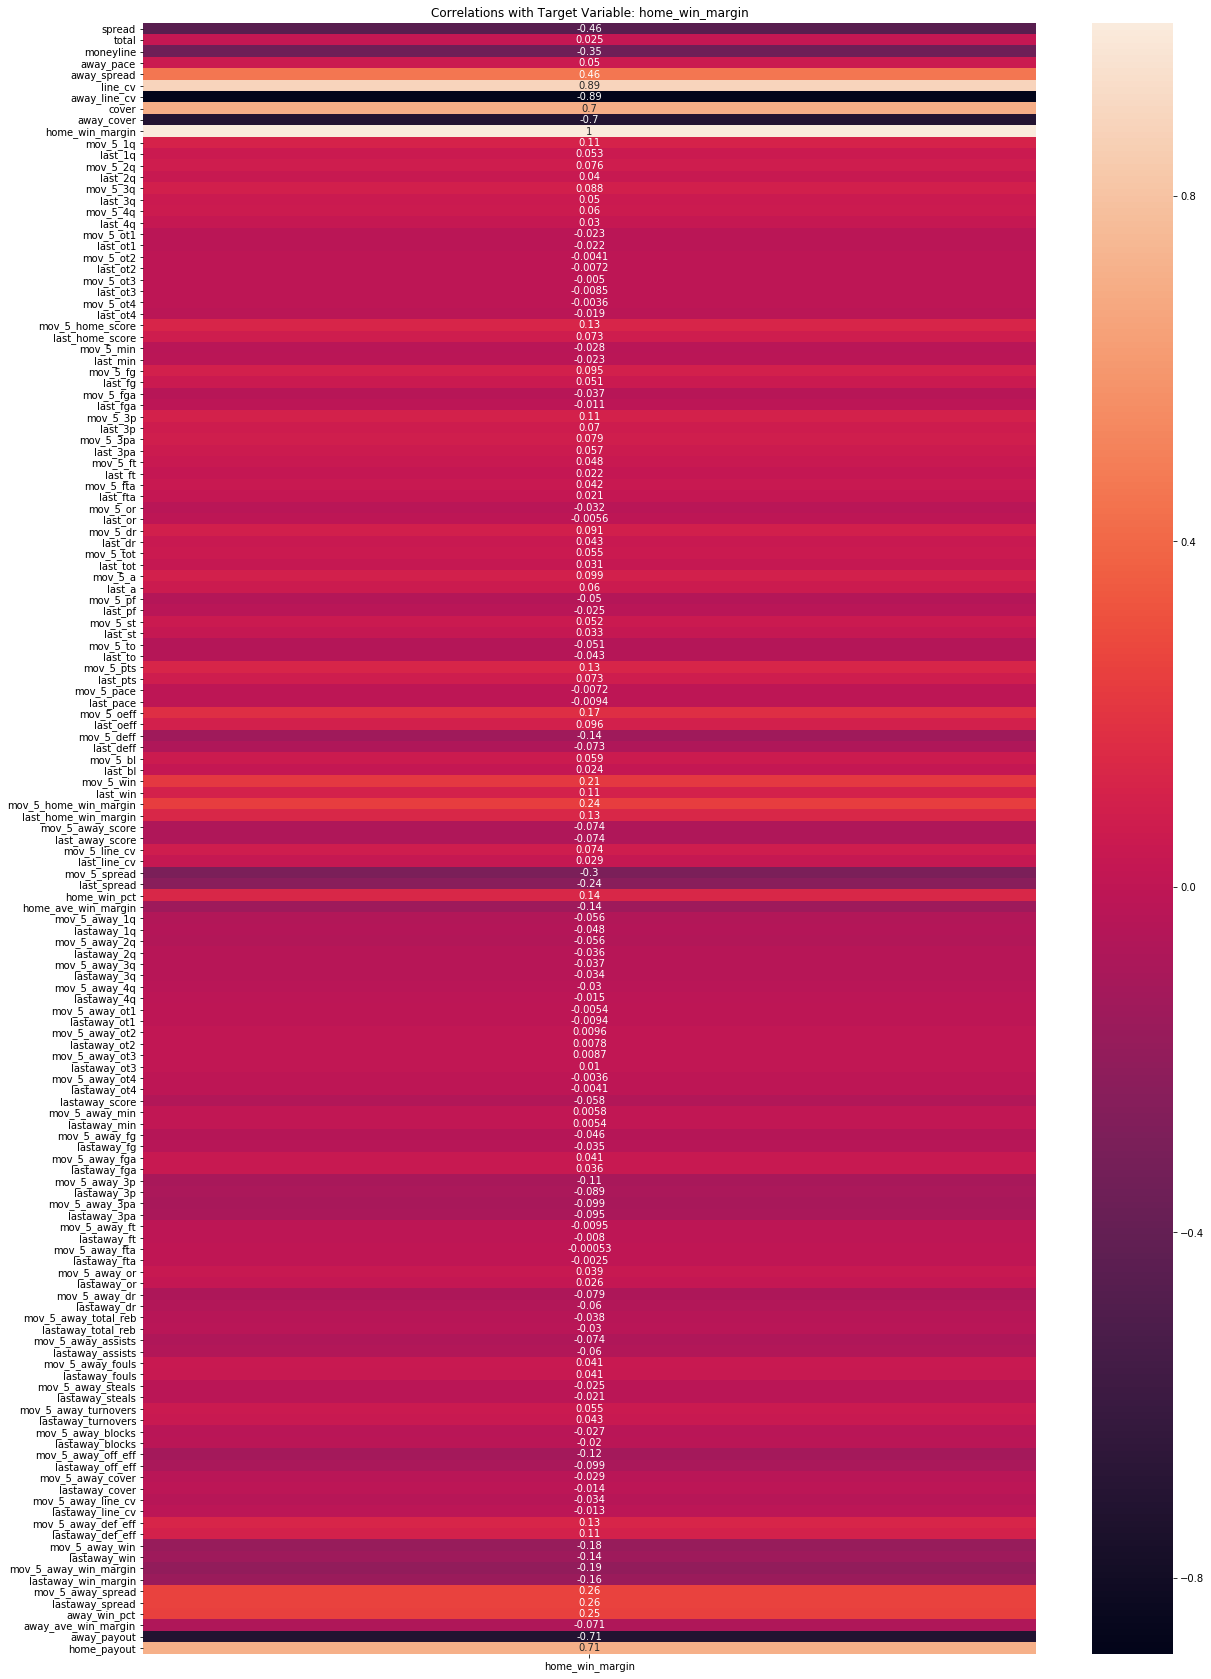

In [257]:
graph.plotheatc('home_win_margin')

#### Spread 

One would expect the spread to be a predictor of home win margin as it is the line the books put out to divide the action.  The spread should move with the actual win margin.

In [258]:
nba.groupby('spread').cover.mean()

spread
-22.50    1.000000
-21.50    1.000000
-21.00    0.000000
-20.50    1.000000
-20.00    0.000000
-19.50    0.500000
-19.00    0.666667
-18.00    0.166667
-17.50    0.500000
-17.00    0.428571
-16.50    0.312500
-16.00    0.521739
-15.50    0.382353
-15.00    0.585366
-14.50    0.535714
-14.00    0.283333
-13.50    0.486486
-13.00    0.411111
-12.50    0.442308
-12.00    0.454545
-11.50    0.433824
-11.00    0.509677
-10.50    0.521127
-10.45    1.000000
-10.00    0.468085
-9.50     0.517766
-9.00     0.486486
-8.50     0.500000
-8.00     0.426829
-7.50     0.507246
            ...   
 1.50     0.515000
 2.00     0.442105
 2.50     0.502959
 3.00     0.467290
 3.50     0.500000
 4.00     0.497382
 4.50     0.418994
 5.00     0.418079
 5.50     0.462025
 6.00     0.393939
 6.50     0.421875
 7.00     0.441176
 7.50     0.539326
 8.00     0.478261
 8.50     0.557377
 9.00     0.311475
 9.50     0.375000
 10.00    0.333333
 10.50    0.388889
 11.00    0.764706
 11.50    0.285714
 12.0

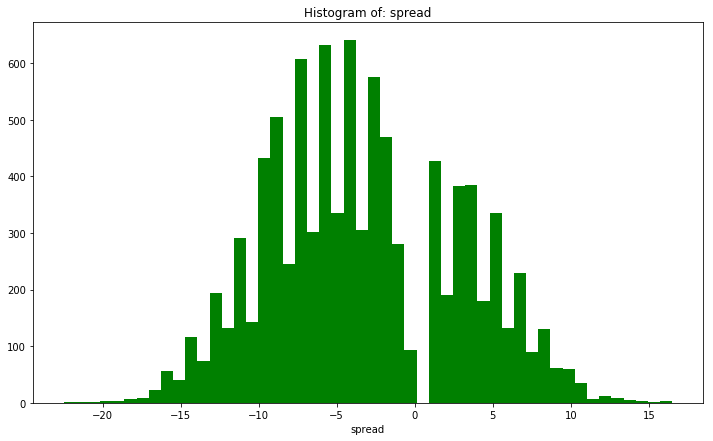

In [259]:
graph.plothist('spread')

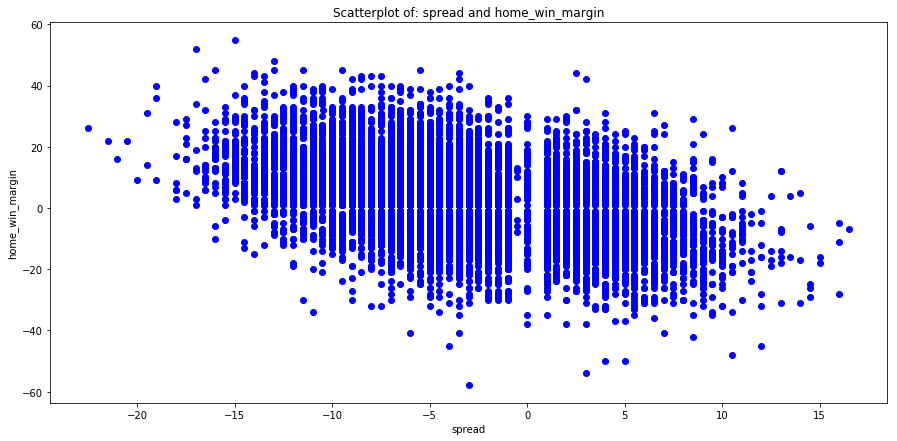

In [260]:
graph.plotscat('spread', 'home_win_margin')

In [261]:
nba.home_win_margin.corr(nba.spread)
#strong negative correlation as expected since line is opposite of win
#margin

-0.45663618199682576

In [262]:
nba['high_alt'] = nba.teams.map(lambda x: 1 if (x == "Denver") or 
                                (x== "Utah") else 0)

### Changing Rest Features to Dummies

The NBA schedule is not fixed and many teams have a different amount or rest entering games.  Last season they changed some rules and started the season earlier to make the season less taxing, but it is still important to account for the various

We will create a variable for each.  This will greatly expand our number of features as will future dummying that is, but the plan is to do feature extraction using Principal Components analysis so the feature increase should not be too onerous on the model.


In [263]:
nba = pd.get_dummies(nba , columns= ['away_rest', 'rest_days'], drop_first= True)

### Teams Dummies

It is also important to distinguish between teams teams venues and support might influence the outcomes of games.  Here we dummy teams accomplish that goal.



In [264]:
#nba = nba = pd.get_dummies(nba, columns = ['teams', 'away_team'], drop_first = True)

### Referee Dummies 

The final dummy conversions are for the referee information.  Three referees generally work an NBA game.  We have the values for each and will convert them to dummies to incorporate any referee tendencies.

In [265]:
#nba = pd.get_dummies(nba, columns = ['ref_1','crew_referees','ref_3'], drop_first = True)

### Cumulative Stats Variables

There are for cumulative stats variable we generated Average win margin and Average win percentage for both home and away variables

In [266]:
#nba.dropna(inplace = True)

In [267]:
#graph.plothist('home_ave_win_margin')

In [268]:
nba.home_ave_win_margin.value_counts()

 1.500000     39
 0.000000     36
 0.500000     35
 1.000000     34
 2.000000     30
-0.500000     29
-2.000000     27
-1.500000     27
-3.000000     23
 1.250000     22
-1.000000     21
 0.750000     21
-2.500000     20
-0.750000     19
 2.250000     19
 2.500000     19
 0.833333     18
 3.000000     18
-0.250000     16
 0.333333     16
 1.750000     16
 2.333333     15
 0.166667     14
 1.333333     14
 0.250000     14
-0.400000     14
-0.166667     14
 1.375000     14
 2.750000     14
-4.000000     13
              ..
 0.089286      1
 2.387500      1
-0.682927      1
-3.616667      1
 3.888889      1
-0.180556      1
-4.863636      1
 1.612903      1
 10.375000     1
-2.977778      1
 5.282609      1
-0.025000      1
-8.125000      1
-2.343750      1
 3.406250      1
 3.978261      1
-5.562500      1
-1.902778      1
 0.217391      1
 3.151515      1
 4.312500      1
-2.968750      1
 1.172414      1
 0.986842      1
-1.240000      1
-3.518519      1
-1.661290      1
 5.425926     

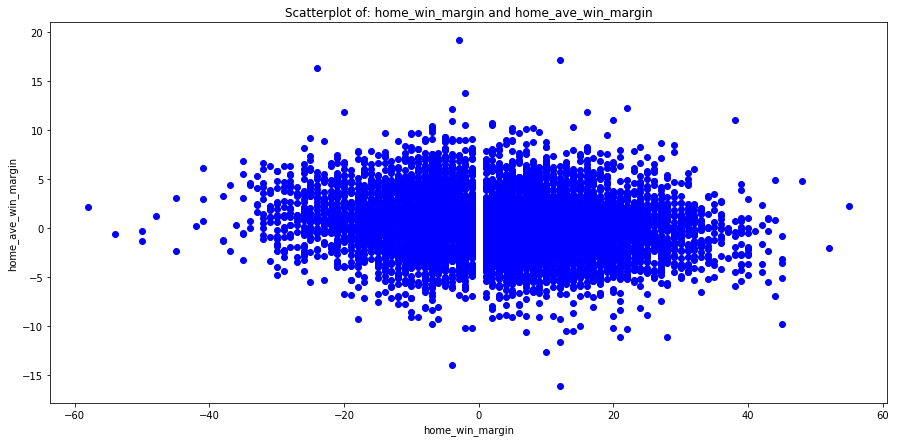

In [269]:
graph.plotscat('home_win_margin', 'home_ave_win_margin')

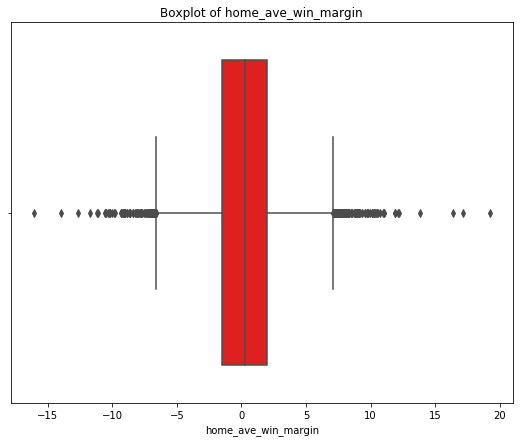

In [270]:
graph.plotbox('home_ave_win_margin')

In [271]:
nba.home_win_margin.corr(nba.home_ave_win_margin)
#strong positive correlation

-0.14489800977593723

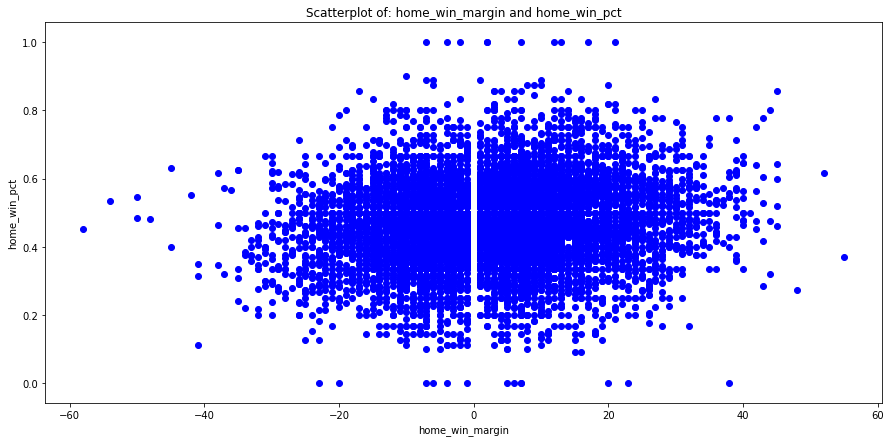

In [272]:
graph.plotscat('home_win_margin', 'home_win_pct')

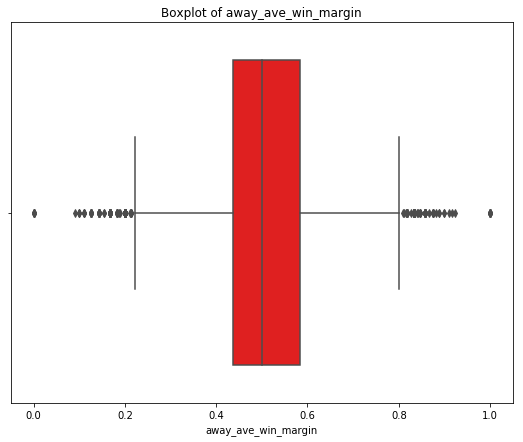

In [273]:
graph.plotbox('away_ave_win_margin')

In [274]:
nba.home_win_margin.corr(nba.home_win_pct)
#strong positive correlation

0.13613958644561944

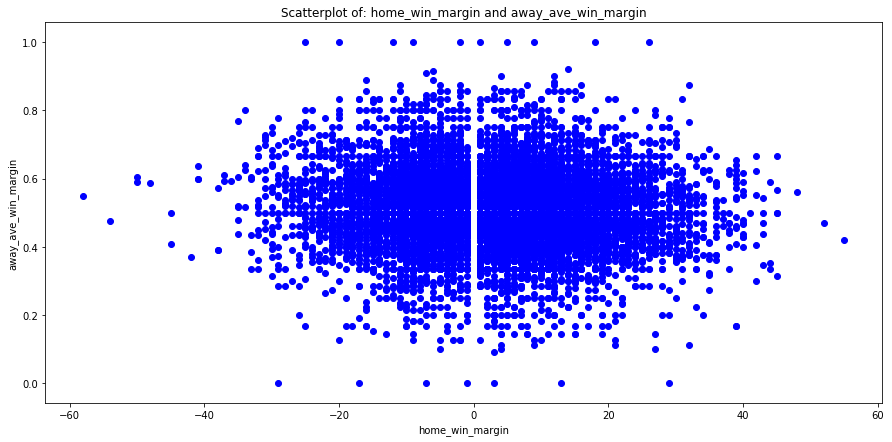

In [275]:
graph.plotscat('home_win_margin', 'away_ave_win_margin')

In [276]:
nba.home_win_margin.corr(nba.away_ave_win_margin)


-0.07091364740819074

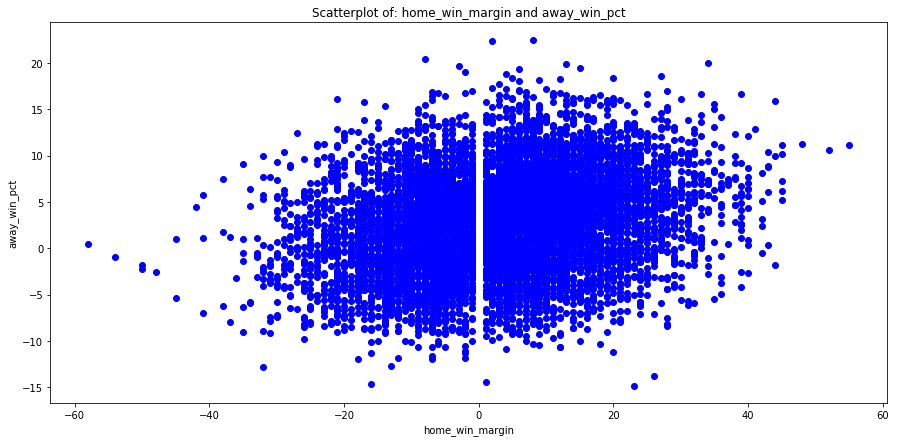

In [277]:
graph.plotscat('home_win_margin', 'away_win_pct')

In [278]:
nba.home_win_margin.corr(nba.away_win_pct)


0.24845497288540022

### Relative Offensive and Defensive efficiencies

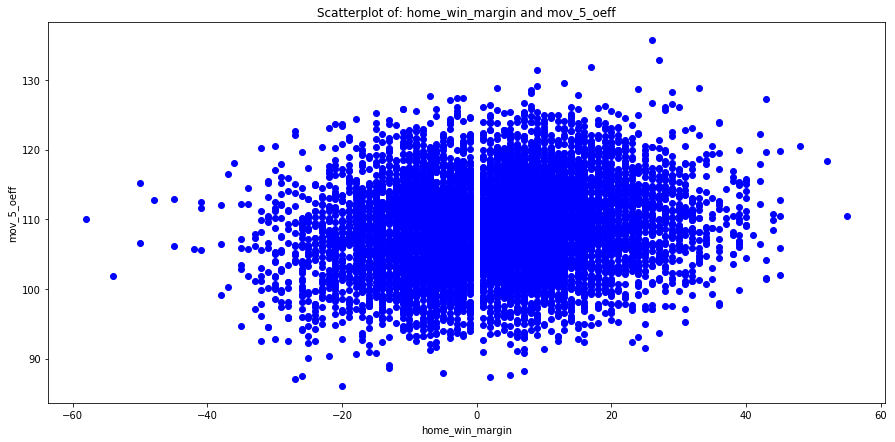

In [279]:

graph.plotscat('home_win_margin', 'mov_5_oeff')



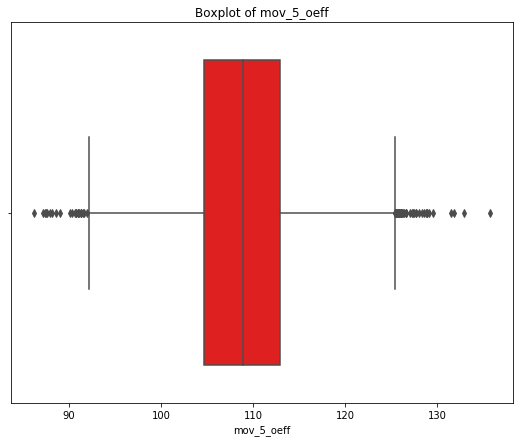

In [280]:
graph.plotbox('mov_5_oeff')

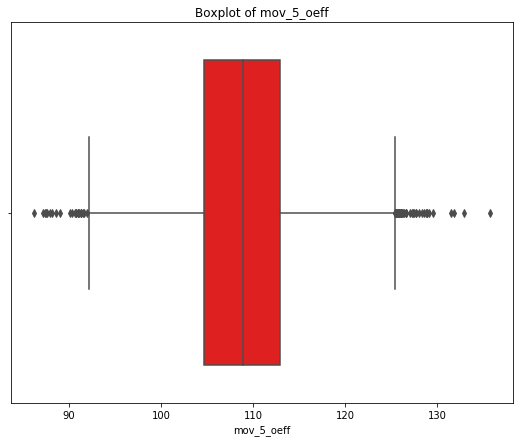

In [281]:
graph.plotbox('mov_5_oeff')

In [282]:
nba.home_win_margin.corr(nba.mov_5_oeff)

0.16993029076678776

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Offensive Efficeincy Numbers')

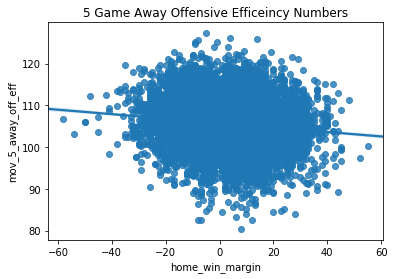

In [283]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_off_eff)
plt.title("5 Game Away Offensive Efficeincy Numbers")

In [284]:
nba.home_win_margin.corr(nba.mov_5_away_off_eff)

-0.12049705554193314

In [285]:
#eff ratio ratio by line for 3 and 5 game moving averages
nba['eff_ratio1'] = ((nba.mov_5_deff )/(nba.mov_5_away_def_eff ))  
nba['eff_ratio2'] = (nba.mov_5_oeff/ nba.mov_5_away_off_eff) 
nba['eff_ratio3'] = ((nba.last_deff )/(nba.lastaway_def_eff ))  
nba['eff_ratio4'] = (nba.last_oeff/ nba.lastaway_off_eff)  

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Offensive efficiency ratio')

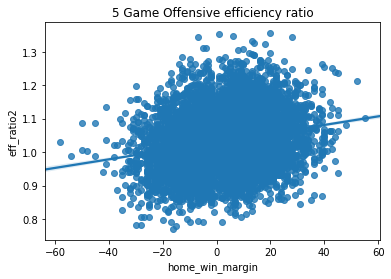

In [286]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.eff_ratio2)
plt.title("5 Game Offensive efficiency ratio")

In [287]:
nba.home_win_margin.corr(nba.eff_ratio1)

-0.19567207513997126

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Win Margin Moving Average')

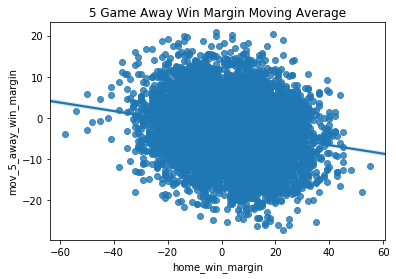

In [288]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_win_margin)
plt.title("5 Game Away Win Margin Moving Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Win Margin Moving Average')

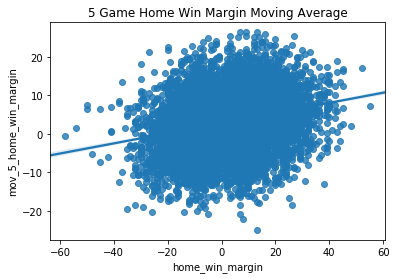

In [289]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_home_win_margin)
plt.title("5 Game Home Win Margin Moving Average")

In [290]:
nba['win_margin_ratio'] = (nba.mov_5_home_win_margin)/(nba.mov_5_away_win_margin)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Win Margin Moving Average')

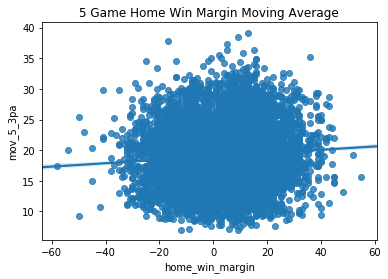

In [291]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_3pa)
plt.title("5 Game Home Win Margin Moving Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away 3 Point Attempts')

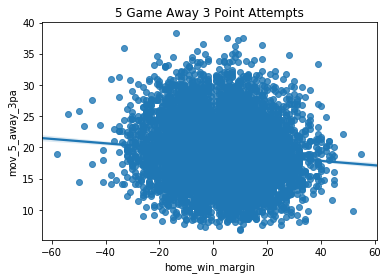

In [292]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_3pa)
plt.title("5 Game Away 3 Point Attempts")

In [293]:
nba['home_score_margin'] = nba.mov_5_home_score*nba.home_ave_win_margin
nba['away_score_margin'] = nba.mov_5_away_score*nba.away_ave_win_margin

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Score * Cumulative Win Margin')

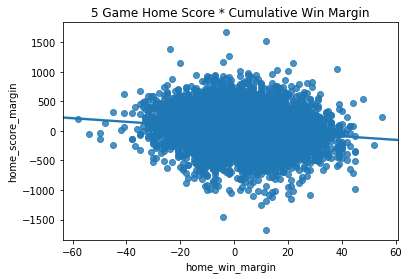

In [294]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.home_score_margin)
plt.title("5 Game Home Score * Cumulative Win Margin")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Score * Cumulative Away Win Margin')

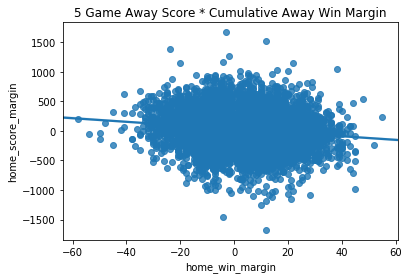

In [295]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.home_score_margin)
plt.title("5 Game Away Score * Cumulative Away Win Margin")

###  Traveling to High Altitude Locations

Traveling to high altitude locations can be tiring for players not used to altitude.  Check to see if these location make a difference.

#### Assists

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Away Assist Average')

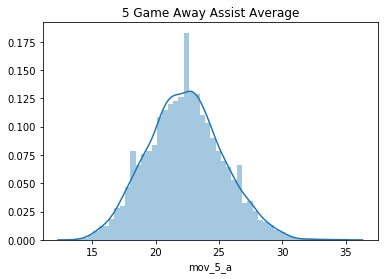

In [296]:
plt.gcf()
sns.distplot(nba.mov_5_a)
plt.title("5 Game Away Assist Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Assist Average')

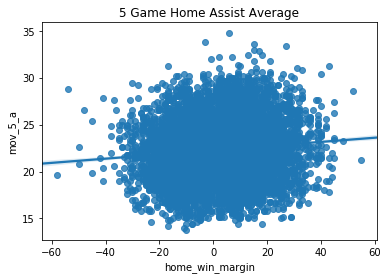

In [297]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_a)
plt.title("5 Game Home Assist Average")

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Assist Average')

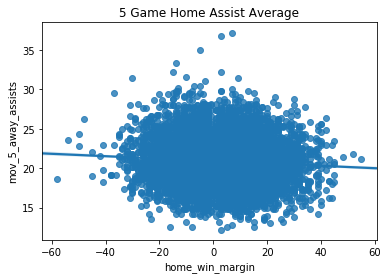

In [298]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.mov_5_away_assists)
plt.title("5 Game Home Assist Average")

In [299]:
assist_ratio = nba.mov_5_a/nba.mov_5_away_assists

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'5 Game Home Assist Average')

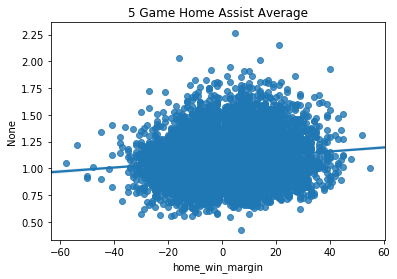

In [300]:
plt.gcf()
sns.regplot(nba.home_win_margin, assist_ratio)
plt.title("5 Game Home Assist Average")

#### Three Point Attempts

### Travel from West Coast/ East Coast

It is hypothesized that Traveling from West Coast to East Coast is more difficult as losing time makes it tougher to acclimate.  Check to see if this is a factor

In [301]:

### Travel Distance

In [302]:
nba.dataset.value_counts()

2007-2008 Regular Season    1061
2006-2007 Regular Season    1058
2008-2009 Regular Season     983
2009-2010 Regular Season     982
2010-2011 Regular Season     980
2014-2015 Regular Season     914
2013-2014 Regular Season     914
2012-2013 Regular Season     903
2011-2012 Regular Season     758
2009 Playoffs                 85
2008 Playoffs                 83
2007 Playoffs                 78
2010 Playoffs                 76
2015 Playoffs                 75
2013 Playoffs                 67
2011 Playoffs                 63
2012 Playoffs                 61
2014 Playoffs                 58
Name: dataset, dtype: int64

### Playoff Games

Currently, the data sets contain both regular season and playoff games.  Here I create a feature dummy variable that indicates the game is a playoff game.

In [303]:
nba['playoff_game'] = nba.dataset.map(lambda x:1 if x[5] =='P' else 0)

In [304]:
nba.playoff_game.value_counts()

0    8553
1     646
Name: playoff_game, dtype: int64

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'playoff games')

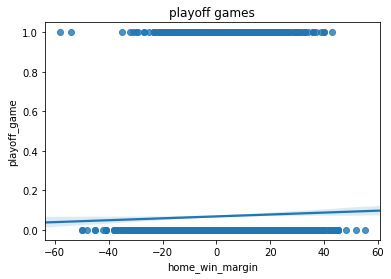

In [305]:
plt.gcf()
sns.regplot(nba.home_win_margin, nba.playoff_game)
plt.title("playoff games")

### Problem with Traditional Metrics

Our first models concentrated on traditional metrics such as scoring and effeciency numbers did not have any explanatory power in predicting the spread.  Some of this is due to the fact that the spread is created using these numbers so they do not predict better than the spread.  So while we will keep some of these variable in the model.  We are going to try and look for combinations that might explain subsets of results that would not be incorporated in the full model.  

#### Small Away team dogs coming off a outright win






In [306]:
nba['feature_1'] = 0
nba['feature_1'][(nba.lastaway_win == 1) &
                 (nba.spread < -3) & 
                 (nba.spread > -10)] = 1
                 

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [307]:

nba[nba.feature_1 == 1].cover.mean()


0.5608695652173913

### Winning Away Teams coming off a loss and are small favs

In [308]:
nba['feature_1'] = 0
nba['feature_1'][(nba.lastaway_win == 1) &
                 (nba.spread < -3) & 
                 (nba.spread > -10)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [309]:
nba_test['feature_1'] = 0
nba_test['feature_1'][(nba_test.lastaway_win == 1) &
                 (nba_test.spread < -3) & 
                 (nba_test.spread > -10)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [310]:
nba.feature_1.value_counts()

0    8969
1     230
Name: feature_1, dtype: int64

In [311]:
nba[nba.feature_1 == 1].cover.mean()

0.5608695652173913

In [312]:
nba['feature_2'] = 0
nba['feature_2'][(nba.lastaway_win == 0) &
                 (nba.spread > 0) & 
                 (nba.spread < 10)] = 1

nba[nba.feature_2 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5993377483443708

In [313]:
nba_test['feature_2'] = 0
nba_test['feature_2'][(nba_test.lastaway_win == 0) &
                 (nba_test.spread > 0) & 
                 (nba_test.spread < 10)] = 1



/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [314]:
nba.feature_2.value_counts()

0    8897
1     302
Name: feature_2, dtype: int64

In [315]:
nba['feature_3'] = 0
nba['feature_3'][(nba.last_win == 0) &
                 (nba.spread > 4) & 
                 (nba.spread < 10)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [316]:
nba_test['feature_3'] = 0
nba_test['feature_3'][(nba_test.last_win == 0) &
                 (nba_test.spread > 4) & 
                 (nba_test.spread < 10)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [317]:
nba[nba.feature_3 == 1].away_cover.mean()

0.5622435020519836

In [318]:
nba.feature_3.value_counts()

0    8468
1     731
Name: feature_3, dtype: int64

In [319]:
nba['feature_4'] = 0
nba['feature_4'][(nba.mov_5_win < .4) &
                 (nba.spread < 9.5) & 
                 (nba.spread > 2)] = 1
nba[nba.feature_4 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5409556313993175

In [320]:
nba_test['feature_4'] = 0
nba_test['feature_4'][(nba_test.mov_5_win < .4) &
                 (nba_test.spread < 9.5) & 
                 (nba_test
                  .spread > 2)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [321]:
nba.feature_4.value_counts()

0    8613
1     586
Name: feature_4, dtype: int64

In [322]:
nba['feature_5'] = 0
nba['feature_5'][(nba.mov_5_away_win < .6) &
                 (nba.spread < 20) & 
                 (nba.spread > 0)] = 1
nba[nba.feature_5 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.547104580812446

In [323]:
nba_test['feature_5'] = 0
nba_test['feature_5'][(nba_test.mov_5_away_win < .6) &
                 (nba_test.spread < 20) & 
                 (nba_test.spread > 0)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [324]:
nba['feature_6'] = 0
nba['feature_6'][(nba.lastaway_win == 0) &
                 (nba.spread < 20) & 
                 (nba.spread > -1)] = 1
nba[nba.feature_6 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5913312693498453

In [325]:
nba_test['feature_6'] = 0
nba_test['feature_6'][(nba_test.lastaway_win == 0) &
                 (nba_test.spread < 20) & 
                 (nba_test.spread > -1)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [326]:
nba.feature_6.value_counts()

0    8876
1     323
Name: feature_6, dtype: int64

In [327]:
nba['feature_7'] = 0
nba['feature_7'][(nba.last_win == 0) &
                 (nba.spread < 20) & 
                 (nba.spread > 4)] = 1
nba[nba.feature_7 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5570552147239264

In [328]:
nba_test['feature_7'] = 0
nba_test['feature_7'][(nba_test.last_win == 0) &
                 (nba_test.spread < 20) & 
                 (nba_test.spread > 4)] = 1

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [329]:
nba.feature_7.value_counts()

0    8384
1     815
Name: feature_7, dtype: int64

In [330]:
nba['feature_8'] = 0
nba['feature_8'] [( nba.mov_5_tot > nba.mov_5_away_total_reb) &
                   (nba.mov_5_win < .2)] = 1
nba[nba.feature_8 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.6407766990291263

In [331]:
nba.feature_8.value_counts()

0    9096
1     103
Name: feature_8, dtype: int64

In [332]:
nba['feature_9'] = 0
nba['feature_9'] [( nba.mov_5_away_total_reb> nba.mov_5_tot) &
                   (nba.mov_5_away_win < .2)] = 1
nba[nba.feature_9 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.5625

In [333]:
nba.feature_9.value_counts()

0    8895
1     304
Name: feature_9, dtype: int64

In [334]:
nba['feature_10'] = 0
nba['feature_10'] [(nba.mov_5_win < .4) &
                 (nba.lastaway_line_cv >5) & 
                 (nba.spread > -9)] = 1
                  
nba[nba.feature_10 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5714285714285714

In [335]:
nba.feature_10.value_counts()

0    8884
1     315
Name: feature_10, dtype: int64

In [336]:
nba['feature_11'] = 0
nba['feature_11'] [(nba.mov_5_win < .6) &
                 (nba.lastaway_line_cv <1) & 
                 (nba.spread > 0)] = 1
                  
nba[nba.feature_11 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5561224489795918

In [337]:
nba.feature_11.value_counts()

0    8415
1     784
Name: feature_11, dtype: int64

In [338]:
nba['feature_12'] = 0
nba['feature_12'] [(nba.mov_5_win == .2) &
                 (nba.lastaway_line_cv <-2) & 
                 (nba.spread < 0)] = 1
                  
nba[nba.feature_12 == 1].cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.567741935483871

In [339]:
nba.feature_12.value_counts()

0    9044
1     155
Name: feature_12, dtype: int64

In [340]:
nba['feature_13'] = 0
nba['feature_13'] [(nba.mov_5_win == .2) &
                 (nba.lastaway_line_cv <-2) & 
                 (nba.spread > 0)] = 1
                  
nba[nba.feature_13 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5567010309278351

In [341]:
nba['feature_14'] = 0
nba['feature_14'] [(nba.lastaway_turnovers > nba.mov_5_away_turnovers) &
                 (nba.lastaway_win == 0) & 
                 (nba.spread > 0)] = 1
                  
nba[nba.feature_14 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.6687116564417178

In [342]:
nba.feature_14.value_counts()

0    9036
1     163
Name: feature_14, dtype: int64

In [343]:
nba['feature_15'] = 0
nba['feature_15'] [(nba.last_to > nba.mov_5_to ) &
                 (nba.last_win == 0) & 
                 (nba.spread > 4)] = 1
                  
nba[nba.feature_15 == 1].away_cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5552631578947368

In [344]:
nba.feature_15.value_counts()

0    8819
1     380
Name: feature_15, dtype: int64

In [345]:
nba['feature_16'] = 0
nba['feature_16'] [(nba.last_home_win_margin < -7 )  & 
                   (nba.mov_5_oeff > nba.mov_5_away_off_eff) &
                   (nba.spread >5)] = 1
                  
nba[nba.feature_16 == 1].cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5681818181818182

In [346]:
nba.feature_16.value_counts()

0    9111
1      88
Name: feature_16, dtype: int64

In [347]:
nba['feature_17'] = 0
nba['feature_17'] [(nba.mov_5_away_def_eff> nba.mov_5_deff) &
                 (nba.lastaway_win == 1) & 
                 (nba.spread < -4)] = 1
                  
nba[nba.feature_17 == 1].cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5865384615384616

In [348]:
nba.feature_17.value_counts()

0    9095
1     104
Name: feature_17, dtype: int64

In [349]:
nba['feature_18'] = 0
nba['feature_18'] [(nba.mov_5_away_off_eff> nba.mov_5_oeff) &
                 (nba.lastaway_win == 1) & 
                 (nba.spread < -4)] = 1
                  
nba[nba.feature_18 == 1].cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.5925925925925926

In [350]:
nba.feature_18.value_counts()

0    9118
1      81
Name: feature_18, dtype: int64

In [351]:
nba['feature_19'] = 0
nba['feature_19'] [(nba.mov_5_bl < nba.mov_5_away_blocks) &
                 (nba.lastaway_win == 1) & 
                 (nba.spread < -4)] = 1
                  
nba[nba.feature_19 == 1].cover.mean()

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.6363636363636364

In [352]:
nba.feature_19.value_counts()

0    9133
1      66
Name: feature_19, dtype: int64

In [353]:
nba.to_csv('./data/nba_analysis_data.csv', index = False)

In [354]:
nba.columns[200:]

Index(['feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18',
       'feature_19'],
      dtype='object')